In [45]:
!nvidia-smi

Thu Jan 23 16:11:54 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   31C    P8              12W / 450W |  21405MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 假设你已有 device, mu1, sigma1, mu2, sigma2 等全局变量
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# 参数设置
dim = 2
batch_size = 64
num_epochs = 1000
lr = 1e-5  # 使用更小的学习率
save_interval = 200
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 混合高斯分布定义（同前）
mu1 = torch.tensor([1.5, 1.5], dtype=torch.float32)
sigma1 = torch.tensor([[1.0, 0.6], [0.6, 1.0]], dtype=torch.float32)
mu2 = torch.tensor([-1.5, -1.5], dtype=torch.float32)
sigma2 = torch.tensor([[1.0, -0.5], [-0.5, 1.0]], dtype=torch.float32)

class MixtureGaussian:
    def sample(self, n):
        n1 = n // 2
        n2 = n - n1
        dist1 = MultivariateNormal(mu1, sigma1)
        dist2 = MultivariateNormal(mu2, sigma2)
        samples = torch.cat([dist1.sample((n1,)), dist2.sample((n2,))], dim=0)
        return samples[torch.randperm(n)]

true_dist = MixtureGaussian()



In [105]:

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            # nn.LayerNorm(dim),
            # nn.ReLU(),
            nn.GELU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return x + self.block(x)

# 密度网络定义（输出非负值）
class DensityNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 512),
            # nn.ReLU(),
            nn.GELU(),
            # nn.LayerNorm(512),
            nn.Linear(512, 512),
            # nn.ReLU(),
            nn.GELU(),
            ResBlock(512),  # 添加残差块
            ResBlock(512),
            nn.Linear(512, 1),
            # nn.Softplus(beta=0.3)
        )


    def forward(self, x):
        return self.net(x) + 1e-6  # 确保数值稳定性

model = DensityNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# 训练循环
print("开始训练密度网络...")

lambda_integral = 1.0  # 初始权重
lambda_mean_constraint = 0.01  # 均值约束的权重

for epoch in range(num_epochs):
    x = true_dist.sample(batch_size).to(device).requires_grad_(True)
    # p = model(x)  # 预测密度值
    logp = -model(x).sum()
    # mean_p = p.mean()
    # lower_loss = torch.relu(-0.00001 - mean_p)        # 当均值小于0.5时施加惩罚
    # upper_loss = torch.relu(mean_p - 1.0)        # 当均值大于2时施加惩罚
    # constraint_loss = lower_loss + upper_loss

    # # 计算得分函数∇log p(x)
    # log_p = torch.log(p)
    # 修改迹项计算逻辑
    s = torch.autograd.grad(logp, x, create_graph=True, retain_graph=True)[0]  # 确保保留计算图
    trace = 0.0
    for i in range(x.size(1)):  # 动态获取维度
        ds_i = s[:, i]
        grad_ds_i = torch.autograd.grad(ds_i.sum(), x, create_graph=True, retain_graph=True)[0][:, i]
        trace += grad_ds_i.mean()
    # loss_mean = 0.5 * (s ** 2).sum(dim=1).mean()

    loss_mean = torch.norm(s, dim=-1) ** 2 / 2.
    loss_mean = loss_mean.mean()
    original_loss = loss_mean + trace
    # 总损失 = 原始损失 + 均值约束损失
    loss = original_loss

    if epoch % 50 == 0:
        print(f"step {epoch}, Loss: {loss.item():.4f}, Mean p: {logp.item():.4f}, trace: {trace.item():.4f},  loss_mean: {loss_mean.item():.4f},")

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
    optimizer.step()

    if (epoch+1) % save_interval == 0:
        torch.save(model.state_dict(), f"density_model_epoch_{epoch+1}.pth")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


print("训练完成!")

开始训练密度网络...
step 0, Loss: 0.0026, Mean p: -5.9921, trace: 0.0020,  loss_mean: 0.0005,
step 50, Loss: -0.3077, Mean p: -34.1554, trace: -0.3622,  loss_mean: 0.0546,
step 100, Loss: -0.6158, Mean p: -53.2407, trace: -0.8535,  loss_mean: 0.2378,
step 150, Loss: -1.0112, Mean p: -53.3504, trace: -1.5675,  loss_mean: 0.5563,
Epoch 200/1000, Loss: -0.8838
step 200, Loss: -0.7581, Mean p: -67.1896, trace: -1.9670,  loss_mean: 1.2090,
step 250, Loss: -1.2882, Mean p: -44.4237, trace: -2.2868,  loss_mean: 0.9986,
step 300, Loss: -1.3089, Mean p: -27.1973, trace: -2.3010,  loss_mean: 0.9921,
step 350, Loss: -1.2096, Mean p: -26.0204, trace: -2.5099,  loss_mean: 1.3002,
Epoch 400/1000, Loss: -1.2060
step 400, Loss: -1.3481, Mean p: -23.8120, trace: -2.5207,  loss_mean: 1.1726,
step 450, Loss: -1.6008, Mean p: -1.1726, trace: -2.4832,  loss_mean: 0.8824,
step 500, Loss: -1.3253, Mean p: -27.6298, trace: -2.6179,  loss_mean: 1.2926,
step 550, Loss: -1.3820, Mean p: -11.3088, trace: -2.5679,  loss_m

In [106]:
loss.shape, logp.shape,trace.shape, loss_mean.shape

(torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]))

In [107]:
trace.mean(), (s**2).sum(dim=1).mean()

(tensor(-2.4759, device='cuda:1', grad_fn=<MeanBackward0>),
 tensor(3.4233, device='cuda:1', grad_fn=<MeanBackward0>))

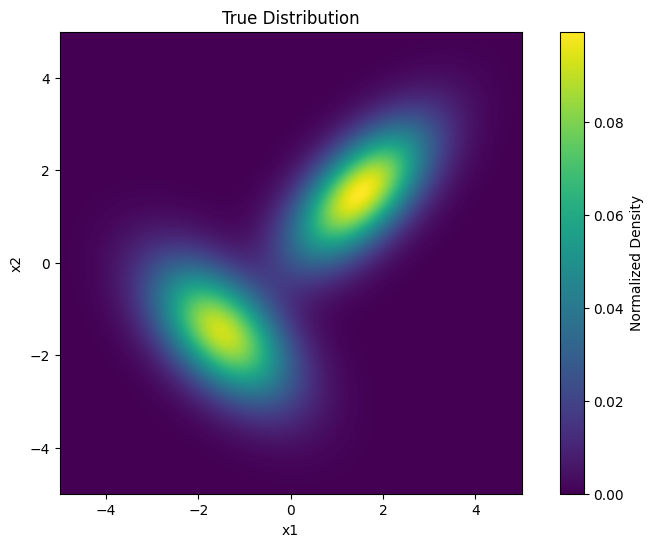

/tmp/ipykernel_3559864/2609555308.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"density_model_epoch_{ckpt_epoch}.pth", map_location=device)


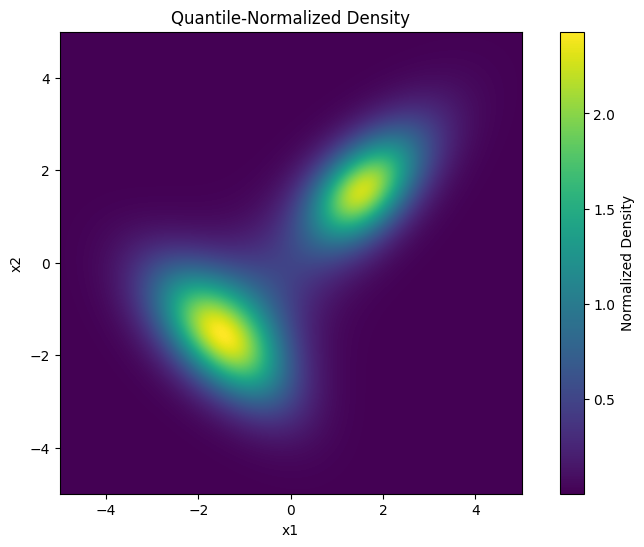

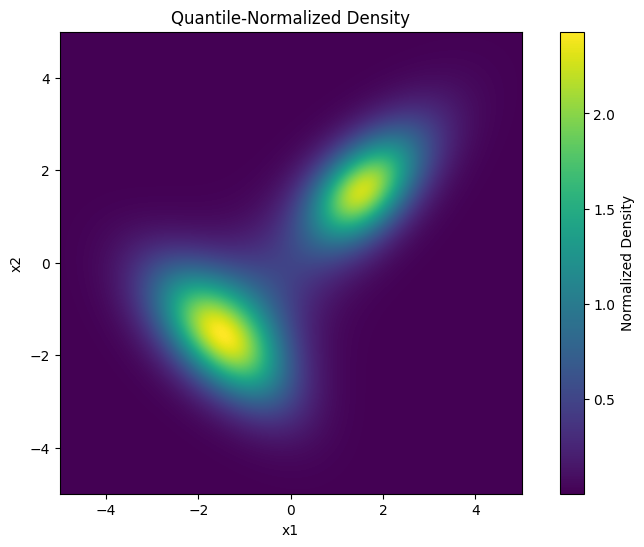

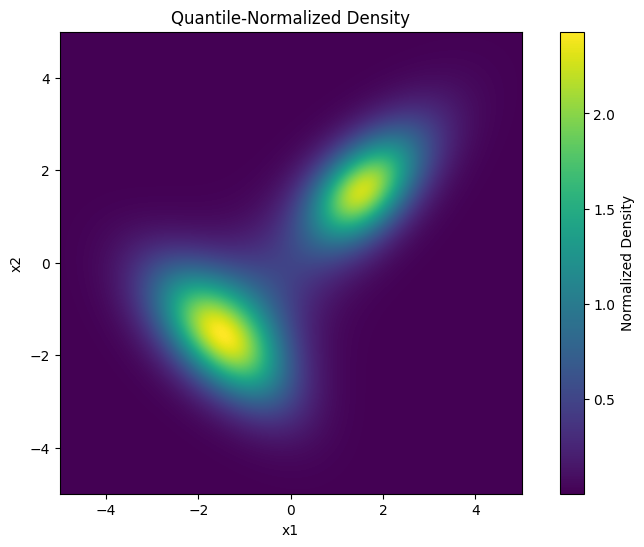

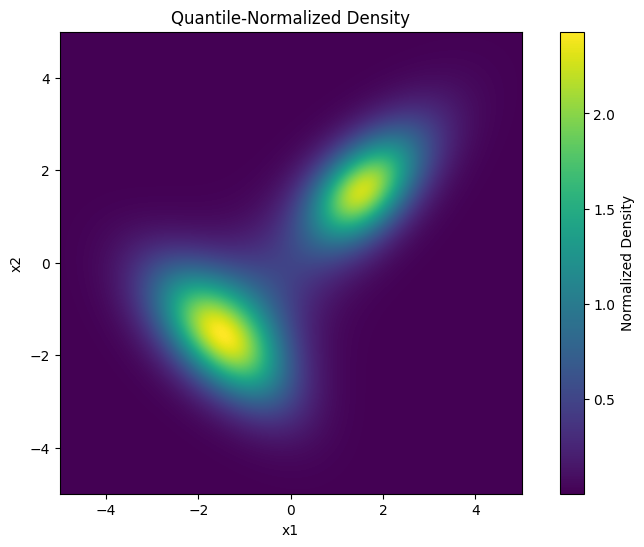

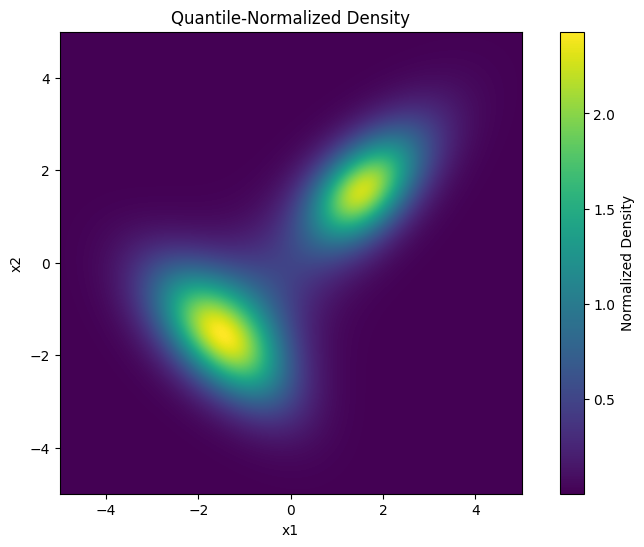

In [108]:


# 1. 生成可视化网格
x_min, x_max = -5, 5
y_min, y_max = -5, 5
n = 500
xx, yy = np.meshgrid(np.linspace(x_min, x_max, n), np.linspace(y_min, y_max, n))

grid_points = np.stack([xx.ravel(), yy.ravel()], axis=-1)
grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

# 2. 计算真实分布 PDF
true_pdf = 0.5 * multivariate_normal(mean=mu1.cpu().numpy(), cov=sigma1.cpu().numpy()).pdf(grid_points) \
         + 0.5 * multivariate_normal(mean=mu2.cpu().numpy(), cov=sigma2.cpu().numpy()).pdf(grid_points)
true_pdf = true_pdf.reshape(xx.shape)

# 3. 定义辅助函数：从网络获取密度并归一化(仅用于可视化)
# def get_model_density(model, grid_tensor, shape_2d):
#     model.eval()
#     with torch.no_grad():
#         # 网络输出 shape: (N,) or (N,1)，先转 numpy
#         densities = model(grid_tensor).squeeze().cpu().numpy()
#     densities = densities.reshape(shape_2d)
#     # 归一化到 [0,1]（仅为了可视化颜色更直观）
#     densities /= (densities.max() + 1e-8)
#     return densities
def get_model_density(model, grid_tensor, shape_2d):
    model.eval()
    with torch.no_grad():
        densities = model(grid_tensor).squeeze() #.cpu().numpy()
        densities = torch.exp(-densities).cpu().numpy()
    densities = densities.reshape(shape_2d)
    densities_normalized = densities
    # densities_normalized = np.clip(densities_normalized, 0, 1)  # 限制在 [0,1]

    # 改进2：对数变换增强低对比度区域
    densities_log = np.log(densities + 1e-8)  # 避免 log(0)
    densities_log_normalized = (densities_log - np.min(densities_log)) / (np.max(densities_log) - np.min(densities_log))

    return densities_normalized, densities_log_normalized
def plot_density(density, title, cmap='viridis'):
    plt.figure(figsize=(10, 6))
    plt.imshow(density, cmap=cmap, origin='lower', extent=[x_min, x_max, y_min, y_max])
    plt.colorbar(label='Normalized Density')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
# 5. 创建子图：第 1 个画真实分布，后面画若干中间 epoch

# 计算我们需要的检查点个数
checkpoints = list(range(save_interval, num_epochs+1, save_interval))
# (a) 绘制真实分布
plot_density(true_pdf, title="True Distribution")

# (b) 依次加载并可视化每个 checkpoint 的模型
for i, ckpt_epoch in enumerate(checkpoints, start=1):
    # 重新实例化模型
    mid_model = DensityNetwork().to(device)  # 假设你之前定义好的网络
    # 加载对应 epoch 权重
    state_dict = torch.load(f"density_model_epoch_{ckpt_epoch}.pth", map_location=device)
    mid_model.load_state_dict(state_dict)
    density_norm, density_log = get_model_density(model, grid_tensor, xx.shape)
    plot_density(density_norm, 'Quantile-Normalized Density')




# sliced score matching

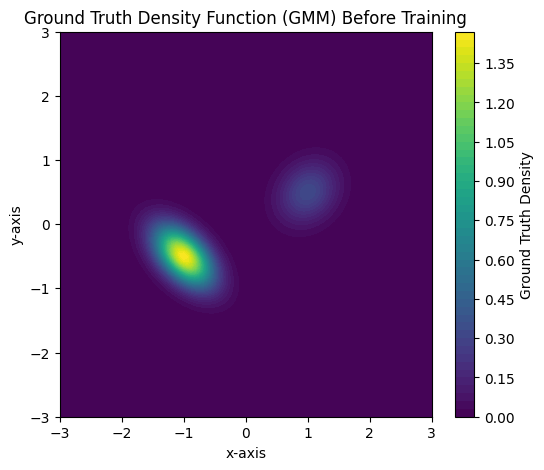

Starting sliced score matching training...
Epoch 0, Loss: 0.005118
Epoch 50, Loss: -6.539725
Epoch 100, Loss: -6.488865
Epoch 150, Loss: -5.311100
Epoch 200, Loss: -5.654236
Epoch 250, Loss: -7.371737
Epoch 300, Loss: -5.663530
Epoch 350, Loss: -6.706960
Epoch 400, Loss: -7.462727
Epoch 450, Loss: -7.030576
Epoch 500, Loss: -6.370150
Epoch 550, Loss: -5.322704
Epoch 600, Loss: -4.904607
Epoch 650, Loss: -6.237698
Epoch 700, Loss: -4.360336
Epoch 750, Loss: -7.349247
Epoch 800, Loss: -6.933050
Epoch 850, Loss: -6.537732
Epoch 900, Loss: -5.841819
Epoch 950, Loss: -5.859157
Training complete!


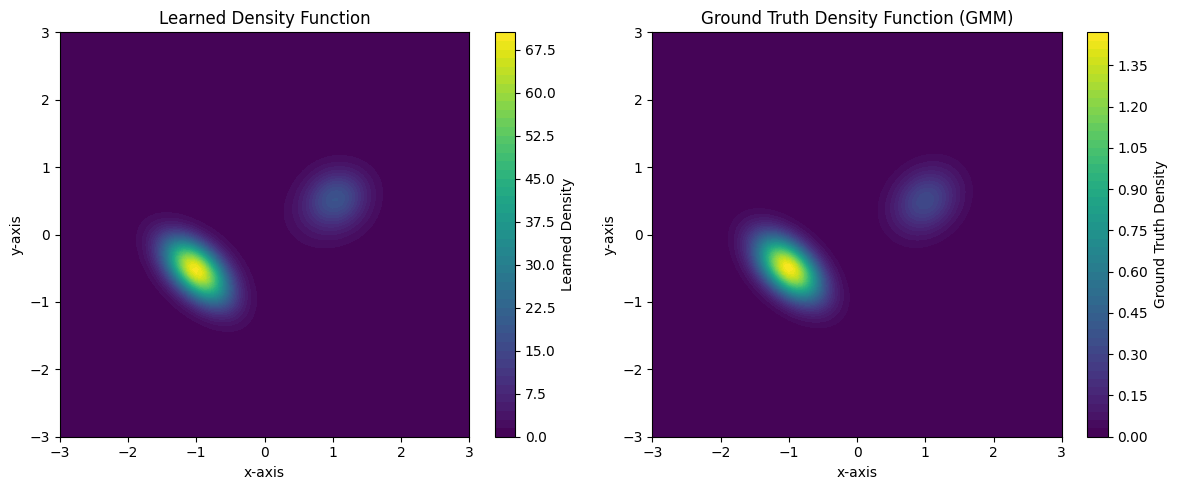

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Define the Residual Block
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return x + self.block(x)

# Define the Density Network
class DensityNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 512),
            nn.GELU(),
            nn.Linear(512, 512),
            nn.GELU(),
            ResBlock(512),
            ResBlock(512),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.net(x) + 1e-6  # Ensuring numerical stability

# Sliced Score Matching Function
def sliced_score_matching(model, x, num_slices=10):
    x = x.requires_grad_(True)
    batch_size, dim = x.shape
    total_loss = 0.0

    for _ in range(num_slices):
        # Generate a random slice direction (normalized)
        random_direction = torch.randn(dim, 1).to(x.device)
        random_direction /= torch.norm(random_direction, dim=0)  # Normalize

        # Project data onto the slice
        projected_x = torch.matmul(x, random_direction).squeeze()

        # Compute the score (gradient of log density)
        logp = -model(x).sum()
        score = torch.autograd.grad(logp, x, create_graph=True, retain_graph=True)[0]

        # Project the score onto the slice
        sliced_score = torch.matmul(score, random_direction).squeeze()

        # Compute the gradient of the sliced score
        sliced_score_grad = torch.autograd.grad(sliced_score.sum(), x, create_graph=True, retain_graph=True)[0]

        # Compute the trace term
        trace_term = (sliced_score_grad * random_direction.T).sum(dim=-1).mean()

        # Compute the loss for this slice
        slice_loss = 0.5 * (sliced_score ** 2).mean() + trace_term

        total_loss += slice_loss

    return total_loss / num_slices

# Initialize the model, optimizer, and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DensityNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 1000
batch_size = 128
num_slices = 10  # Number of slices for SSM

# Define a Gaussian Mixture Model (GMM) as the ground truth distribution
gmm_weights = torch.tensor([0.2, 0.8])
gmm_means = torch.tensor([[1.0, 0.5], [-1.0, -0.5]])
gmm_covariances = torch.tensor([[[0.1, 0.02], [0.02, 0.1]], [[0.1, -0.05], [-0.05, 0.1]]])

true_dist = torch.distributions.Categorical(gmm_weights)
components = [
    torch.distributions.MultivariateNormal(gmm_means[i], gmm_covariances[i]) for i in range(len(gmm_weights))
]
def sample_gmm(batch_size):
    indices = true_dist.sample((batch_size,))
    return torch.stack([components[i].sample() for i in indices], dim=0)

def gmm_log_prob(grid):
    log_probs = torch.stack([components[i].log_prob(grid) + torch.log(gmm_weights[i]) for i in range(len(gmm_weights))], dim=0)
    return torch.logsumexp(log_probs, dim=0)

# Visualize ground truth density before training
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

# Compute ground truth density using GMM
with torch.no_grad():
    ground_truth_density = torch.exp(gmm_log_prob(grid_tensor.cpu())).cpu().numpy().reshape(xx.shape)

# Plot ground truth density before training
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, ground_truth_density, levels=50, cmap='viridis')
plt.colorbar(label='Ground Truth Density')
plt.title('Ground Truth Density Function (GMM) Before Training')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

print("Starting sliced score matching training...")

for epoch in range(num_epochs):
    # Sample data from the true distribution
    x = sample_gmm(batch_size).to(device)

    # Compute the sliced score matching loss
    loss = sliced_score_matching(model, x, num_slices)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()

    # Log training progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training complete!")

# Visualization of Learned vs Ground Truth Density
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

# Use the trained model to predict density values
model.eval()
with torch.no_grad():
    learned_density = model(grid_tensor)
    learned_density = torch.exp(-learned_density).cpu().numpy().reshape(xx.shape)

# Compute ground truth density using GMM
with torch.no_grad():
    ground_truth_density = torch.exp(gmm_log_prob(grid_tensor.cpu())).cpu().numpy().reshape(xx.shape)

# Plot learned density
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, learned_density, levels=50, cmap='viridis')
plt.colorbar(label='Learned Density')
plt.title('Learned Density Function')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

# Plot ground truth density
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, ground_truth_density, levels=50, cmap='viridis')
plt.colorbar(label='Ground Truth Density')
plt.title('Ground Truth Density Function (GMM)')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

plt.tight_layout()
plt.show()


In [118]:
# Visualization of Learned vs Ground Truth Density
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)



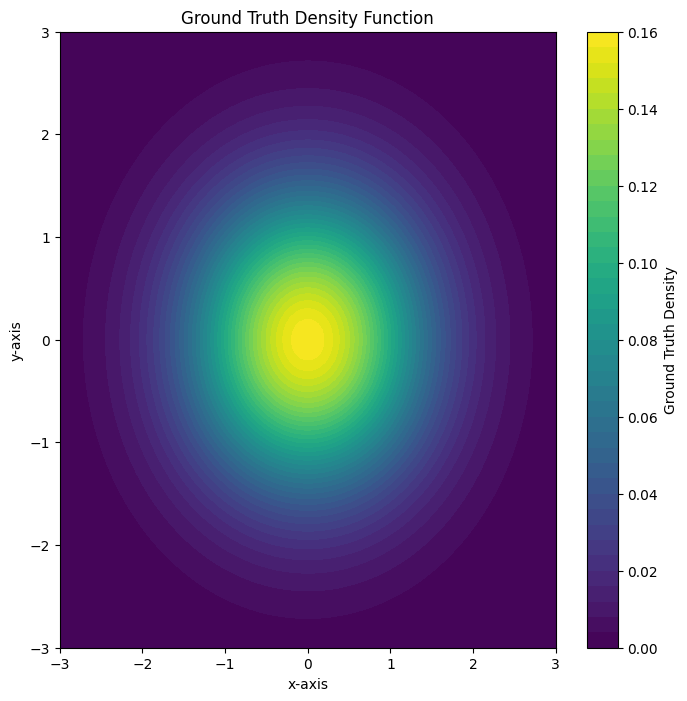

In [119]:

# Compute ground truth density
with torch.no_grad():
    ground_truth_density = torch.exp(true_dist.log_prob(grid_tensor.cpu())).cpu().numpy().reshape(xx.shape)
plt.figure(figsize=(8,8))
plt.contourf(xx, yy, ground_truth_density, levels=50, cmap='viridis')
plt.colorbar(label='Ground Truth Density')
plt.title('Ground Truth Density Function')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

In [ ]:

print("Starting sliced score matching training...")

for epoch in range(num_epochs):
    # Sample data from the true distribution
    x = true_dist.sample((batch_size,)).to(device)

    # Compute the sliced score matching loss
    loss = sliced_score_matching(model, x, num_slices)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()

    # Log training progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training complete!")


In [111]:
model = model.to(device)

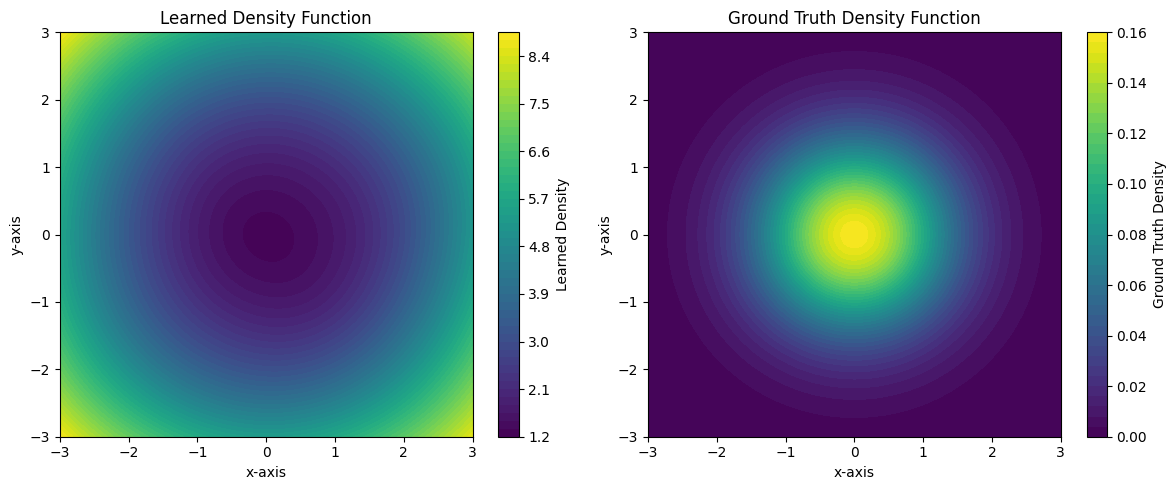

In [113]:


# Use the trained model to predict density values
model.eval()
with torch.no_grad():
    learned_density = model(grid_tensor).cpu().numpy().reshape(xx.shape)

# Plot learned density
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, learned_density, levels=50, cmap='viridis')
plt.colorbar(label='Learned Density')
plt.title('Learned Density Function')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

# Plot ground truth density
plt.subplot(1, 2, 2)


plt.tight_layout()
plt.show()
